In [382]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
from scipy import integrate
from scipy import signal
from scipy.signal import find_peaks
import os
from os import getcwd
from glob import glob

In [516]:
#A function that opens the file and separates each of the four columns, removes the bias and current offsets,
#and removes the voltage drop from the femto and lines

#Input arguments:
#path: define the file location and the file in the form: "\filelocation\filename"
#dc_fac: DC factor can be found in the lab notebook
#femto: gain setting (V/A)
#R: resistor in the lock-in (Ohms)

#returns:
#v_corr: corrected voltage bias. Offset and line voltage drop removed
#dI_dV: corrected conductance spectrum. differentiated g_int wrt v_corr
#g_oop: untreated out-of-plane conductance
#g_int: integral of g. representative of the 

def remove_Rs(path, dc_fac, femto, R):
    
    with open(path) as f:
        lines = f.readlines()
        x0 = [float(line.split()[0]) for line in lines]
        x1 = [float(line.split()[1]) for line in lines]
        x2 = [float(line.split()[2]) for line in lines]
        y1 = [float(line.split()[3]) for line in lines]
        
    v = [x*dc_fac for x in x0]           #raw data bias
    g = [y1/femto/R for y1 in x1]        #raw data conductance (S)
    g_oop = [y1/femto/R for y1 in x2]    #raw data out-of-plane conductance (S)
    i_raw = [z/femto for z in y1]            #raw data current (A)
    
    #Using the scipy.signal.peakfind, we next identify the indices of the peaks (peakind) 
    #NormalData
    #peakind, properties = find_peaks(g, distance=750, prominence=(2e-05, 5.33296e-03))  # when the function does not work, distance may often help
    
    #SIN_data_zeroInjection
    peakind, properties = find_peaks(g, distance=50, prominence=(4.0e-05, 5.33296e-03))  # when the function does not work, distance may often help
    #g, prominence=(4.0e-05, 1.0e-03)
    
    #Visualization 1
    #plt.plot([x*1e3 for x in v],[y*1e3 for y in g], color='black', label='g(v_bias) raw data')
    
    #for i in range(0,len(peakind)):
    #    plt.plot(v[peakind[i]]*1e3, g[peakind[i]]*1e3, 'x')
        
    #plt.xlabel("Voltage bias (mV)")
    #plt.ylabel("g (mS)")
        
    print(peakind)
    print(properties)
    
    if len(peakind) == 2:
                
        #The center of the peaks corresponds to the bias offset
        v_offset = (v[peakind[1]]+v[peakind[0]])*0.5
        #print (v_offset)
    
        #Removing the offset from the data
        v_bare = [x-v_offset for x in v]
        
        #Visualization 2
        #plt.plot([x*1e3 for x in v],[y*1e3 for y in g], color='black', label='raw data')
        #plt.plot([x*1e3 for x in v_bare],[y*1e3 for y in g], color='red', label='bias offset removed')
        #plt.legend()
        #plt.xlim(0.30,0.6)
        #plt.ylim(1.2,1.5)
        #plt.xlabel("Voltage bias (mV)")
        #plt.ylabel("g (mS)")
        
        #Next, remove the current offset using the IV curve. To this, we first use the v_bare to be
        #the x-axis of the IV curve, and from there, we identify the  value of I(0) and force it to be 0.
        
        z=min(np.absolute(v_bare))       #take the absolute value of the a_new and find the minimum, which corresponds to the number closest to zero if it is not zero. 
        
        p = z in v_bare
        
        if p==True:                          #use an if-statement to find the index of that minimum element of v_bare as we took its absolute value to identify the minimum but it can be positive or negative. 
            v_bare_min= v_bare.index(z)      
        else: 
            v_bare_min= v_bare.index(-z)
            
        I_offset= i_raw[v_bare_min]          # I-offset is defined by the current value at the zero bias.
        i_bare = [x-I_offset for x in i_raw]  # d_new is the checked current
        
        #Visualization 3
        #print(z)
        #print(v_bare)
        #print(v_bare_min)
        #print(I_offset)
        #plt.plot([x*1e3 for x in v], [y*1e6 for y in i], color='black')
        #plt.plot([x*1e3 for x in v_bare], [y*1e6 for y in i_bare], color='red')
        #plt.plot([x*1e3 for x in v_bare], [y*1e6 for y in i_bare], color='blue')
        #plt.xlim(-0.1,0.1)
        #plt.ylim(-0.005,0.005)
        #plt.xlabel("Voltage bias (mV)")
        #plt.ylabel("I (uA)")
        
        #For sanity check, we want to integrate g wrt v_bare, and compare it with the (v_bare, i_bare) plot.
        #Ideally, they should be the same but since g is measured with the lock-in, it turns out to be smoother
        #than I, so we must use the integral of g instead of i in succeeding calculation.
        
        g_integration = integrate.cumtrapz(g,v_bare)
        g_integ=np.append(g_integration, g_integration[-1])
        I_offset2 = g_integ[v_bare_min]
        g_int = [x-I_offset2 for x in g_integ]
        
        #visualization4
        #plt.plot([x*1e3 for x in v_bare], [y*1e6 for y in i_bare], color='black', label='current, I')
        #plt.plot([x*1e3 for x in v_bare], [y*1e6 for y in g_int], color='red', label='integrated conductance, g_int')
        #plt.xlabel("Voltage bias (mV)")
        #plt.ylabel("I (uA)")
        #plt.legend()
        
        #Now, we want to remove the voltage drop contribution from the femto and the lines using Kirchoff's rule,
        #and knowing that the femto input impedance is 120 Ohms for 10^6 gain and another 120 Ohms from measuring
        #the lines, which gives a total of 240 Ohms for unwanted voltage drop.
        
        if femto == 1e6:
            R_femto=60
        else :
            R_femto=150
        
        
        R_lines=120
        R_ser= R_femto + R_lines

        v_corr= [y - x*R_ser for y, x in zip(v_bare, g_int)]

        #print(len(g_int))
        #print(len(v_corr))

        #next, we take the derivative of g_int wrt the v_corr

        dIdV = np.gradient(g_int, v_corr)
        plt.plot([x*1e3 for x in v_bare], [y*1e3 for y in g], color='black', label='raw data')
        plt.plot([x*1e3 for x in v_corr], [y*1e3 for y in dIdV], color='red', label='R_s removed')
        
        dIdV_new=dIdV
    
        leftrange= range(0,peakind[0]-150)
        rightrange= range(peakind[1]+150, len(dIdV)-3)
    
        for i in itertools.chain(leftrange,rightrange):
            if abs(dIdV_new[i+1]-dIdV_new[i]) > 8.5e-6:
                dIdV_new[i]=(dIdV_new[i+3]+dIdV_new[i-3])*0.5
                #print(i)
            
        for i in range(-2,0):
            dIdV_new[i]=dIdV_new[-3]
            

    
        plt.plot([x*1e3 for x in v_corr], [y*1e3 for y in dIdV_new], color='blue', label='R_s & Outliers removed')
        plt.xlabel('Voltage bias (mV)')
        plt.ylabel('Conductance (mS)')
        #plt.xlim(0.79, 0.80)
        #plt.ylim(1.15, 3.2)
        plt.legend()
    else:
                
        print('Error: Peakfind properties have to be changed. Copy lines 15 thru 28 on a new cell, and change prominence bound to "(None, 1)". Then open the file with these lines of codes and add print(properties["prominences"], change the prominence bounds inside the function based from these values.')
    
    
    return v_corr, dIdV, dIdV_new, g_int

In [517]:
#Finding files with the same file name: useful for injection data
#One needs to define the path which contains directories we will call roots and
#each root will also contain subdirectories, that will contain the files wanted.

def findfile(path, filename):
    flist=[]
    for (root, subdirs, files) in os.walk(path):
        for f in files:
            if filename in f :
                #print("File Found:", os.path.join(root, f))
                flist.append(os.path.join(root, f))
    flist.sort()
    return flist

# Here, we check if the functions work well. We try to call the functions to open treat and plot the resulting data.

[1082 1927]
498
499
500
2498
2499
2500


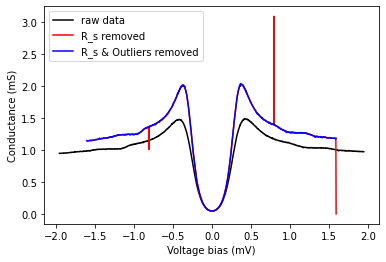

In [454]:
file=glob('189_GIV*.txt', root_dir = 'Sample 20231030/20241231')
path= 'Sample 20231030/20241231/%s' %file[0]
dc_fac =9.739E-3
femto = 1e6
R = 5e-6

v_189, dIdV_189, dIdV_189new,I_189 = remove_Rs(path, dc_fac,femto,R)
#plt.xlim(-1.25,-1.15)
#plt.ylim(1,1.05)

[1084 1934]
498
499
500
2498
2499
2500


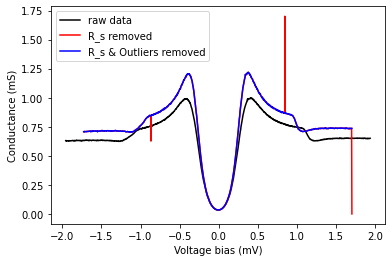

In [407]:
file=glob('190_GIV*.txt', root_dir = 'Sample 20231030/20241231')
path= 'Sample 20231030/20241231/%s' %file[0]
dc_fac =9.739E-3
femto = 1e6
R = 5e-6

v_190, dIdV_190, dIdV_190new,I_190 = remove_Rs(path, dc_fac,femto,R)

[1033 1962]
498
499
500
2498
2499
2500


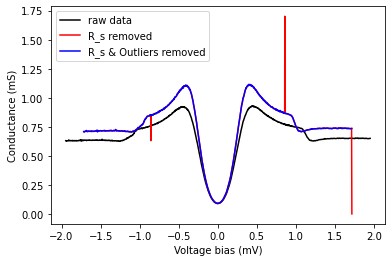

In [406]:
file=glob('191_GIV*.txt', root_dir = 'Sample 20231030/20241231')
path= 'Sample 20231030/20241231/%s' %file[0]
dc_fac =9.739E-3
femto = 1e6
R = 5e-6

v_191, dIdV_191, dIdV_191new,I_191 = remove_Rs(path, dc_fac,femto,R)

[1019 1993]
498
499
500
2498
2499
2500


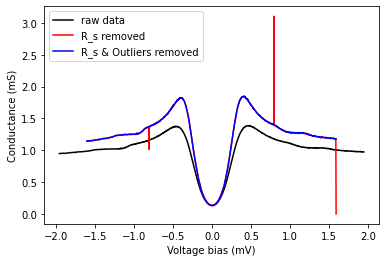

In [408]:
file=glob('192_GIV*.txt', root_dir = 'Sample 20231030/20241231')
path= 'Sample 20231030/20241231/%s' %file[0]
dc_fac =9.739E-3
femto = 1e6
R = 5e-6

v_192, dIdV_192, dIdV_192new,I_192 = remove_Rs(path, dc_fac,femto,R)

[1129 1887]
498
499
500
2498
2499
2500


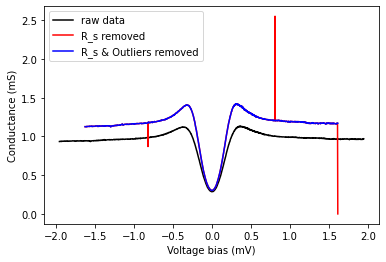

In [409]:
file=glob('194_GIV*.txt', root_dir = 'Sample 20231030/20241231')
path= 'Sample 20231030/20241231/%s' %file[0]
dc_fac =9.739E-3
femto = 1e6
R = 5e-6

v_194, dIdV_194, dIdV_194new,I_194 = remove_Rs(path, dc_fac,femto,R)

[1103 1933]
498
499
500
2498
2499
2500


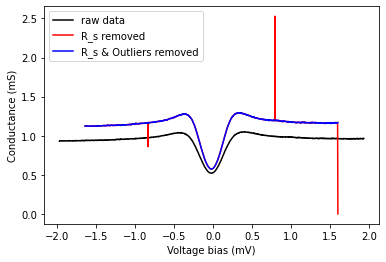

In [410]:
file=glob('195_GIV*.txt', root_dir = 'Sample 20231030/20241231')
path= 'Sample 20231030/20241231/%s' %file[0]
dc_fac =9.739E-3
femto = 1e6
R = 5e-6

v_195, dIdV_195, dIdV_195new,I_195 = remove_Rs(path, dc_fac,femto,R)

[ 974 2012]
498
499
500
2498
2499
2500


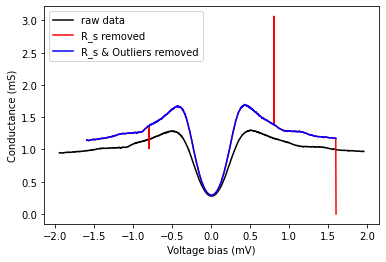

In [411]:
file=glob('197_GIV*.txt', root_dir = 'Sample 20231030/20241231')
path= 'Sample 20231030/20241231/%s' %file[0]
dc_fac =9.739E-3
femto = 1e6
R = 5e-6

v_197, dIdV_197, dIdV_197new,I_197 = remove_Rs(path, dc_fac,femto,R)

[1004 2017]
498
499
500
2498
2499
2500


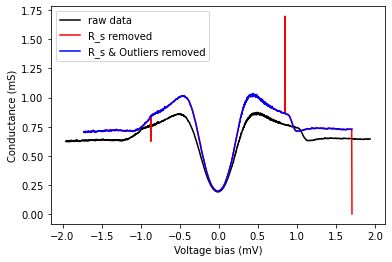

In [412]:
file=glob('198_GIV*.txt', root_dir = 'Sample 20231030/20241231')
path= 'Sample 20231030/20241231/%s' %file[0]
dc_fac =9.739E-3
femto = 1e6
R = 5e-6

v_198, dIdV_198, dIdV_198new,I_198 = remove_Rs(path, dc_fac,femto,R)

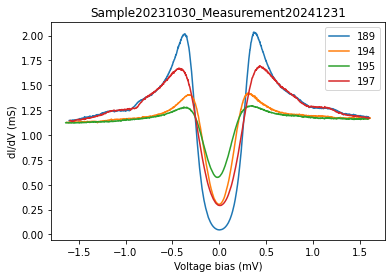

In [413]:
plt.plot([x*1e3 for x in v_189], [y*1e3 for y in dIdV_189new], label='189')
#plt.plot([x*1e3 for x in v_190], [y*1e3 for y in dIdV_190new], label='190')
#plt.plot([x*1e3 for x in v_191], [y*1e3 for y in dIdV_191new], label='191')
#plt.plot([x*1e3 for x in v_192], [y*1e3 for y in dIdV_192new], label='192')
#plt.plot([x*1e3 for x in v_193], [y*1e3 for y in dIdV_193new], label='193')
plt.plot([x*1e3 for x in v_194], [y*1e3 for y in dIdV_194new], label='194')
plt.plot([x*1e3 for x in v_195], [y*1e3 for y in dIdV_195new], label='195')
#plt.plot([x*1e3 for x in v_196], [y*1e3 for y in dIdV_196new], label='196')
plt.plot([x*1e3 for x in v_197], [y*1e3 for y in dIdV_197new], label='197')
plt.title('Sample20231030_Measurement20241231')
plt.xlabel('Voltage bias (mV)')
plt.ylabel('dI/dV (mS)')
#plt.xlim(-1.4, -.0)
#plt.ylim(0, 3)
plt.legend()


# SIS

First, we want to find the path location of the zero-injection SIS junctions ()

In [424]:
flist1=findfile('Sample 20231030/20241218', 'Inj0.txt')
print(flist1)

['Sample 20231030/20241218/122_GIVvsInjJ11_J6toO3_17Hz_5uV_100mK/Inj0.txt', 'Sample 20231030/20241218/123_GIVvsInjJ11_J6toO3_17Hz_5uV_100mK/Inj0.txt', 'Sample 20231030/20241218/124_GIVvsInjJ11_J6toO3_17Hz_5uV_100mK/Inj0.txt', 'Sample 20231030/20241218/125_GIVvsInjJ10_J11toO3_17Hz_5uV_100mK/Inj0.txt', 'Sample 20231030/20241218/126_GIVvsInjJ10_J11toO3_17Hz_5uV_100mK/Inj0.txt', 'Sample 20231030/20241218/127_GIVvsInjJ10_J11toO3_17Hz_5uV_100mK/Inj0.txt', 'Sample 20231030/20241218/128_GIVvsInjJ10_J9toO3_17Hz_5uV_100mK/Inj0.txt', 'Sample 20231030/20241218/129_GIVvsInjJ10_J9toO3_17Hz_5uV_100mK/Inj0.txt', 'Sample 20231030/20241218/130_GIVvsInjJ10_J9toO3_17Hz_5uV_100mK/Inj0.txt', 'Sample 20231030/20241218/131_GIVvsInjJ9_J6toO3_17Hz_5uV_100mK/Inj0.txt', 'Sample 20231030/20241218/132_GIVvsInjJ9_J6toO3_17Hz_5uV_100mK/Inj0.txt', 'Sample 20231030/20241218/133_GIVvsInjJ9_J11toO3_17Hz_5uV_100mK/Inj0.txt', 'Sample 20231030/20241218/134_GIVvsInjJ9_J11toO3_17Hz_5uV_100mK/Inj0.txt']


Text(0, 0.5, 'g (mS)')

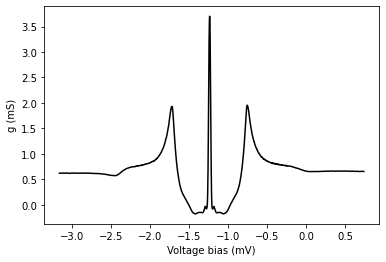

In [425]:

with open(flist1[0]) as f:
        lines = f.readlines()
        x0 = [float(line.split()[0]) for line in lines]
        x1 = [float(line.split()[1]) for line in lines]
        x2 = [float(line.split()[2]) for line in lines]
        y1 = [float(line.split()[3]) for line in lines]
        
v = [x*dc_fac for x in x0]           #raw data bias
g = [y1/femto/R for y1 in x1]        #raw data conductance (S)
g_oop = [y1/femto/R for y1 in x2]    #raw data out-of-plane conductance (S)
i_raw = [z/femto for z in y1]            #raw data current (A)
    
#Using the scipy.signal.peakfind, we next identify the indices of the peaks (peakind) 
#peakind, properties = find_peaks(g, distance=750,  prominence=(2e-05, 5.33296e-03))
    
#Visualization 1
plt.plot([x*1e3 for x in v],[y*1e3 for y in g], color='black', label='g(v_bias) raw data')
    
#for i in range(0,len(peakind)):
#    plt.plot(v[peakind[i]]*1e3, g[peakind[i]]*1e3, 'x')
        
plt.xlabel("Voltage bias (mV)")
plt.ylabel("g (mS)")
        
#print(peakind)
#print(properties)

[1315 2122]


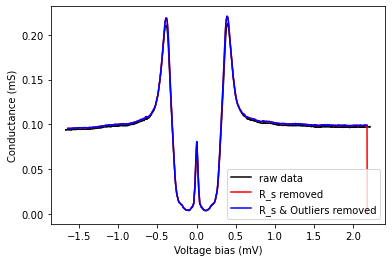

In [422]:
dc_fac =9.739E-3
femto = 1e6
R = 5e-6

v_122, dIdV_122, g_oop_122,I_122 = remove_Rs(flist1[0], dc_fac,femto,R)

# SIN

Here, we treat the SIN junctions and estimate the barrier transparency.


In [ ]:
#Taking the derivative of dIdV(new)
#To identiy the presence of a second gap, we want to take the derivative of dIdV(new)

In [480]:
SIN_flist = findfile('Sample 20231030/20241129', 'Inj0.txt')
print(len(SIN_flist))
for i in range(len(SIN_flist)):
    print(SIN_flist[i])

25
Sample 20231030/20241129/079_GIVvsInjJ6_J10toO3_17Hz_5uV_100mK/Inj0.txt
Sample 20231030/20241129/080_GIVvsInjJ6_J10toO3_17Hz_5uV_100mK/Inj0.txt
Sample 20231030/20241129/083_GIVvsInjJ6_J10toO3_17Hz_5uV_100mK_H150mV/Inj0.txt
Sample 20231030/20241129/086_GIVvsInjJ10_J6toO3_17Hz_5uV_100mK_H150mV/Inj0.txt
Sample 20231030/20241129/086_GIVvsInjJ10_J6toO3_17Hz_5uV_100mK_H150mV_noisy/Inj0.txt
Sample 20231030/20241129/087_GIVvsInjJ10_J6toO3_17Hz_5uV_100mK_H150mV/Inj0.txt
Sample 20231030/20241129/088_GIVvsInjJ10_J6toO3_17Hz_5uV_100mK/Inj0.txt
Sample 20231030/20241129/089_GIVvsInjJ10_J6toO3_17Hz_5uV_100mK/Inj0.txt
Sample 20231030/20241129/090_GIVvsInjJ10_J6toO3_17Hz_5uV_100mK_H150mV/Inj0.txt
Sample 20231030/20241129/091_GIVvsInjJ10_J6toO3_17Hz_5uV_100mK/Inj0.txt
Sample 20231030/20241129/092_GIVvsInjJ7_J9toO3_17Hz_5uV_100mK/Inj0.txt
Sample 20231030/20241129/092_GIVvsInjJ7_J9toO3_17Hz_5uV_100mK_noisy/Inj0.txt
Sample 20231030/20241129/093_GIVvsInjJ7_J9toO3_17Hz_5uV_100mK/Inj0.txt
Sample 20231030/2

In [481]:
#For Non-Inj0.txt zero-injection filenames
SIN_flist2 = findfile('Sample 20231030/20241129', 'Inj48.txt')
print(len(SIN_flist2))
for i in range(len(SIN_flist2)):
    print(SIN_flist2[i])

9
Sample 20231030/20241129/087_GIVvsInjJ10_J6toO3_17Hz_5uV_100mK_H150mV/Inj48.txt
Sample 20231030/20241129/088_GIVvsInjJ10_J6toO3_17Hz_5uV_100mK/Inj48.txt
Sample 20231030/20241129/090_GIVvsInjJ10_J6toO3_17Hz_5uV_100mK_H150mV/Inj48.txt
Sample 20231030/20241129/091_GIVvsInjJ10_J6toO3_17Hz_5uV_100mK/Inj48.txt
Sample 20231030/20241129/093_GIVvsInjJ7_J9toO3_17Hz_5uV_100mK/Inj48.txt
Sample 20231030/20241129/094_GIVvsInjJ7_J9toO3_17Hz_5uV_100mK_H150mV/Inj48.txt
Sample 20231030/20241129/112_GIVvsInjJ10_J9toO3_17Hz_5uV_100mK_H150mV/Inj48.txt
Sample 20231030/20241129/114_GIVvsInjJ9_J6toO3_17Hz_5uV_100mK_H150mV/Inj48.txt
Sample 20231030/20241129/119_GIVvsInjJ11_J6toO3_17Hz_5uV_100mK_H150mV/Inj48.txt


In [512]:
#For Non-Inj0.txt zero-injection filenames
SIN_flist3 = findfile('Sample 20231030/20241129', 'Inj46.txt')
print(len(SIN_flist3))
for i in range(len(SIN_flist3)):
    print(SIN_flist3[i])

10
Sample 20231030/20241129/087_GIVvsInjJ10_J6toO3_17Hz_5uV_100mK_H150mV/Inj46.txt
Sample 20231030/20241129/088_GIVvsInjJ10_J6toO3_17Hz_5uV_100mK/Inj46.txt
Sample 20231030/20241129/090_GIVvsInjJ10_J6toO3_17Hz_5uV_100mK_H150mV/Inj46.txt
Sample 20231030/20241129/091_GIVvsInjJ10_J6toO3_17Hz_5uV_100mK/Inj46.txt
Sample 20231030/20241129/093_GIVvsInjJ7_J9toO3_17Hz_5uV_100mK/Inj46.txt
Sample 20231030/20241129/094_GIVvsInjJ7_J9toO3_17Hz_5uV_100mK_H150mV/Inj46.txt
Sample 20231030/20241129/105_GIVvsInjJ11_J6toO3_17Hz_5uV_100mK_H150mV/Inj46.txt
Sample 20231030/20241129/112_GIVvsInjJ10_J9toO3_17Hz_5uV_100mK_H150mV/Inj46.txt
Sample 20231030/20241129/114_GIVvsInjJ9_J6toO3_17Hz_5uV_100mK_H150mV/Inj46.txt
Sample 20231030/20241129/119_GIVvsInjJ11_J6toO3_17Hz_5uV_100mK_H150mV/Inj46.txt


In [522]:
#For Non-Inj0.txt zero-injection filenames
SIN_flist4 = findfile('Sample 20231030/20241129', 'Inj20.txt')
print(len(SIN_flist4))
for i in range(len(SIN_flist4)):
    print(SIN_flist4[i])

17
Sample 20231030/20241129/079_GIVvsInjJ6_J10toO3_17Hz_5uV_100mK/Inj20.txt
Sample 20231030/20241129/080_GIVvsInjJ6_J10toO3_17Hz_5uV_100mK/Inj20.txt
Sample 20231030/20241129/083_GIVvsInjJ6_J10toO3_17Hz_5uV_100mK_H150mV/Inj20.txt
Sample 20231030/20241129/087_GIVvsInjJ10_J6toO3_17Hz_5uV_100mK_H150mV/Inj20.txt
Sample 20231030/20241129/088_GIVvsInjJ10_J6toO3_17Hz_5uV_100mK/Inj20.txt
Sample 20231030/20241129/089_GIVvsInjJ10_J6toO3_17Hz_5uV_100mK/Inj20.txt
Sample 20231030/20241129/090_GIVvsInjJ10_J6toO3_17Hz_5uV_100mK_H150mV/Inj20.txt
Sample 20231030/20241129/091_GIVvsInjJ10_J6toO3_17Hz_5uV_100mK/Inj20.txt
Sample 20231030/20241129/093_GIVvsInjJ7_J9toO3_17Hz_5uV_100mK/Inj20.txt
Sample 20231030/20241129/094_GIVvsInjJ7_J9toO3_17Hz_5uV_100mK_H150mV/Inj20.txt
Sample 20231030/20241129/104_GIVvsInjJ10_J9toO3_17Hz_5uV_100mK_H150mV/Inj20.txt
Sample 20231030/20241129/105_GIVvsInjJ11_J6toO3_17Hz_5uV_100mK_H150mV/Inj20.txt
Sample 20231030/20241129/106_GIVvsInjJ10_J11toO3_17Hz_5uV_100mK_H150mV/Inj20.txt


In [461]:
dc_fac =9.739E-3
femto = 1e6
R = 5e-6

In [462]:
#J6 in the positive current injection (86,87,105,119)

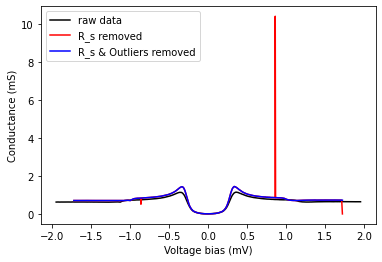

In [463]:
#086 - SIN_flist[3]
v_086, dIdV_086, dIdV_086new,I_086 = remove_Rs(SIN_flist[3], dc_fac,femto,R)

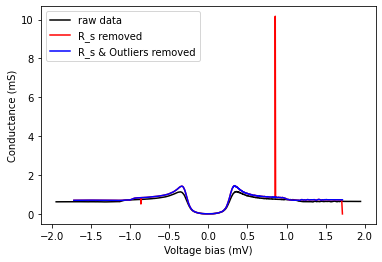

In [464]:
#87 - SIN_flist[5]
v_087, dIdV_087, dIdV_087new,I_087 = remove_Rs(SIN_flist[5], dc_fac,femto,R)

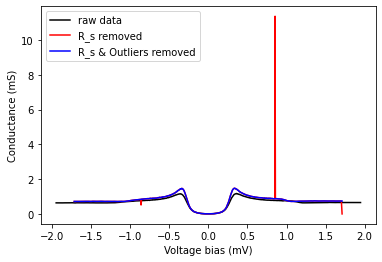

In [467]:
#105 - SIN_flist[15]
v_105, dIdV_105, dIdV_105new,I_105 = remove_Rs(SIN_flist[15], dc_fac,femto,R)

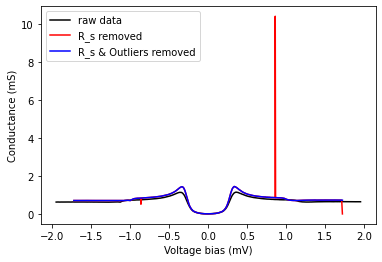

In [468]:
#119 - SIN_flist[3]
v_119, dIdV_119, dIdV_119new,I_119 = remove_Rs(SIN_flist[3], dc_fac,femto,R)

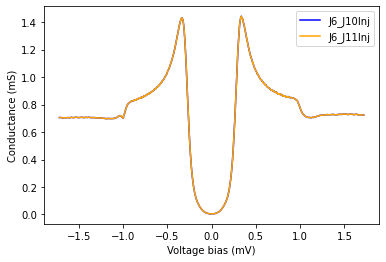

In [477]:
#Comparison of J6 Measurement for current injection in the positive direction

plt.plot([x*1e3 for x in v_086],[y*1e3 for y in dIdV_086new], color='blue', label='J6_J10Inj')
#plt.plot([x*1e3 for x in v_087],[y*1e3 for y in dIdV_087new], color='red', label='J6_J10Inj')
#plt.plot([x*1e3 for x in v_105],[y*1e3 for y in dIdV_105new], color='green', label='J6_J11Inj')
plt.plot([x*1e3 for x in v_119],[y*1e3 for y in dIdV_119new], color='orange',label='J6_J11Inj')

plt.xlabel('Voltage bias (mV)')
plt.ylabel('Conductance (mS)')
#plt.xlim(0.79, 0.80)
#plt.ylim(1.15, 3.2)
plt.legend()

#86-87 are closely similar
#87 is a bit noisy on the high positive bias
#105 has higher peaks but noisier, and lost some features:blip on the negative bias
#86 and 119 are exactly the same 

In [478]:
#J6 towards the negative current injection (90,91,114)

In [ ]:
#89 is SIS

[ 837 1582]
{'prominences': array([0.00051842, 0.00052376]), 'left_bases': array([ 138, 1217]), 'right_bases': array([1203, 2259])}


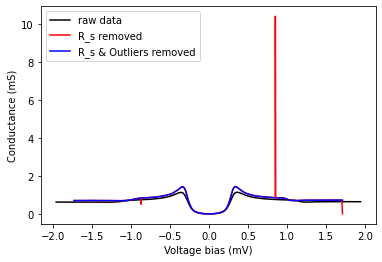

In [496]:
#90 - SIN_flist[8]
v_090, dIdV_090, dIdV_090new,I_090 = remove_Rs(SIN_flist[8], dc_fac,femto,R)

[ 824 1562]
{'prominences': array([0.00053597, 0.00054741]), 'left_bases': array([ 140, 1186]), 'right_bases': array([1184, 2252])}


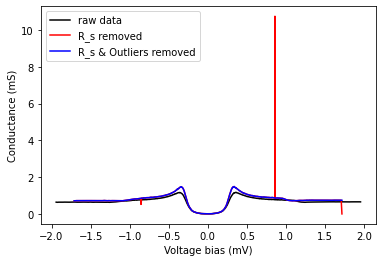

In [499]:
#114 - SIN_flist2[7]
v_114, dIdV_114, dIdV_114new,I_114 = remove_Rs(SIN_flist2[7], dc_fac,femto,R)

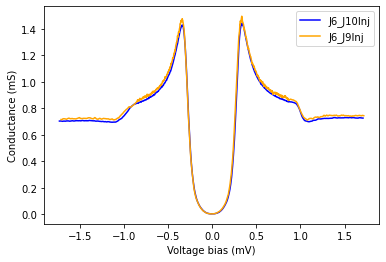

In [500]:
#Comparison of J6 Measurement for current injection in the negative direction

plt.plot([x*1e3 for x in v_090],[y*1e3 for y in dIdV_090new], color='blue', label='J6_J10Inj')
plt.plot([x*1e3 for x in v_114],[y*1e3 for y in dIdV_114new], color='orange',label='J6_J9Inj')

plt.xlabel('Voltage bias (mV)')
plt.ylabel('Conductance (mS)')
#plt.xlim(0.79, 0.80)
#plt.ylim(1.15, 3.2)
plt.legend()

#J9 injection has taller peaks but noisier spectrum than J10 injection

In [ ]:
#J9 in the positive current injection (92,93,94,104)
#92 is incomplete run
#93 is SIS

[ 858 1531]
{'prominences': array([0.00114709, 0.00113945]), 'left_bases': array([ 158, 1196]), 'right_bases': array([1186, 2237])}


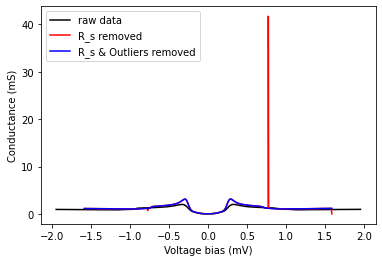

In [505]:
#094 - SIN_flist[13]
v_094, dIdV_094, dIdV_094new,I_094 = remove_Rs(SIN_flist[13], dc_fac,femto,R)

[ 869 1545]
{'prominences': array([0.00113296, 0.00114289]), 'left_bases': array([ 166, 1209]), 'right_bases': array([1202, 2245])}


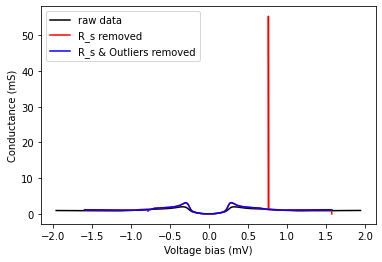

In [506]:
#104 - SIN_flist[14]
v_104, dIdV_104, dIdV_104new,I_104 = remove_Rs(SIN_flist[14], dc_fac,femto,R)

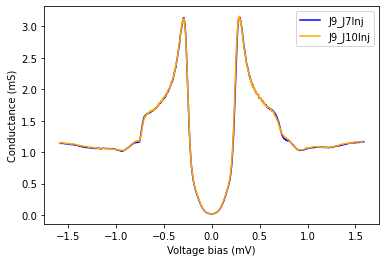

In [511]:
#Comparison of J9 Measurement for current injection in the positive direction

plt.plot([x*1e3 for x in v_094],[y*1e3 for y in dIdV_094new], color='blue', label='J9_J7Inj')
plt.plot([x*1e3 for x in v_104],[y*1e3 for y in dIdV_104new], color='orange',label='J9_J10Inj')

plt.xlabel('Voltage bias (mV)')
plt.ylabel('Conductance (mS)')
#plt.xlim(0.79, 0.80)
#plt.ylim(1.15, 3.2)
plt.legend()

#Main peaks are the same
#J7 injection is smoother and a bit higher
#J10 injection has some problems on the right

In [ ]:
#J9 in the negative current injection (112)

[ 861 1543]
{'prominences': array([0.00112687, 0.00112839]), 'left_bases': array([ 160, 1208]), 'right_bases': array([1198, 2243])}


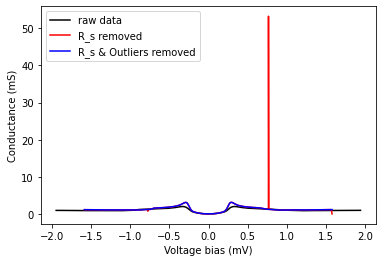

In [518]:
#112 - SIN_flist3[7]
v_112, dIdV_112, dIdV_112new,I_112 = remove_Rs(SIN_flist3[7], dc_fac,femto,R)

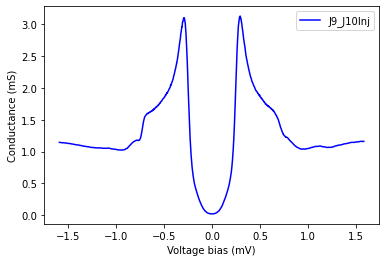

In [519]:
#J9 Measurement for current injection in the negative direction

plt.plot([x*1e3 for x in v_112],[y*1e3 for y in dIdV_112new], color='blue', label='J9_J10Inj')
plt.xlabel('Voltage bias (mV)')
plt.ylabel('Conductance (mS)')
#plt.xlim(0.79, 0.80)
#plt.ylim(1.15, 3.2)
plt.legend()


In [ ]:
#J10 in the positive direction (79,83)

[ 915 1479]
{'prominences': array([4.99730e-05, 4.80656e-05]), 'left_bases': array([  58, 1226]), 'right_bases': array([1167, 2339])}


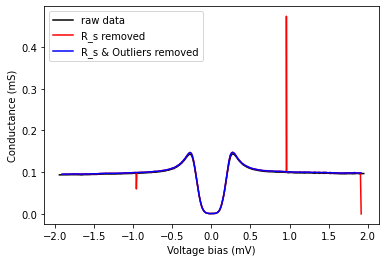

In [526]:
#083 - SIN_flist[2]
v_083, dIdV_083, dIdV_083new,I_083 = remove_Rs(SIN_flist[2], dc_fac,femto,R)

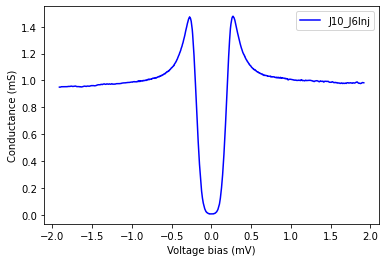

In [528]:
#J10 Measurement for current injection in the positive direction

plt.plot([x*1e3 for x in v_083],[y*1e3*10 for y in dIdV_083new], color='blue', label='J10_J6Inj')
plt.xlabel('Voltage bias (mV)')
plt.ylabel('Conductance (mS)')
#plt.xlim(0.79, 0.80)
#plt.ylim(1.15, 3.2)
plt.legend()

In [ ]:
#J11 in the positive direction (106)

[ 814 1569]
{'prominences': array([0.00078564, 0.00076161]), 'left_bases': array([  10, 1205]), 'right_bases': array([1169, 2395])}


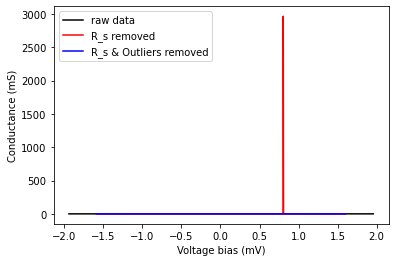

In [529]:
#106 - SIN_flist[16]
v_106, dIdV_106, dIdV_106new,I_106 = remove_Rs(SIN_flist[16], dc_fac,femto,R)

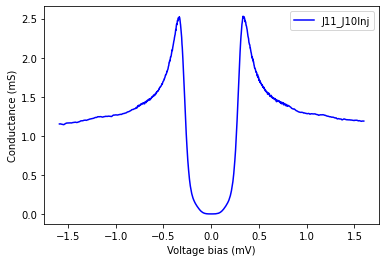

In [530]:
#J11 Measurement for current injection in the positive direction

plt.plot([x*1e3 for x in v_106],[y*1e3 for y in dIdV_106new], color='blue', label='J11_J10Inj')
plt.xlabel('Voltage bias (mV)')
plt.ylabel('Conductance (mS)')
#plt.xlim(0.79, 0.80)
#plt.ylim(1.15, 3.2)
plt.legend()

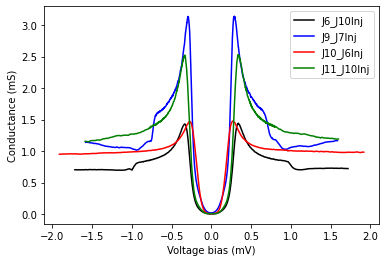

In [532]:
#Comparison of measurement junction (for positive direction of injection)

plt.plot([x*1e3 for x in v_086],[y*1e3 for y in dIdV_086new], color='black', label='J6_J10Inj')
plt.plot([x*1e3 for x in v_094],[y*1e3 for y in dIdV_094new], color='blue', label='J9_J7Inj')
plt.plot([x*1e3 for x in v_083],[y*1e3*10 for y in dIdV_083new], color='red', label='J10_J6Inj')
plt.plot([x*1e3 for x in v_106],[y*1e3 for y in dIdV_106new], color='green', label='J11_J10Inj')

plt.xlabel('Voltage bias (mV)')
plt.ylabel('Conductance (mS)')
#plt.xlim(0.79, 0.80)
#plt.ylim(1.15, 3.2)
plt.legend()


In [553]:
#Taking the derivative of dIdV

def secdIdV(dIdV, v):
    d2IdV2 = np.gradient([x*1e3 for x in dIdV],[y*1e3 for y in v])
    return(d2IdV2)


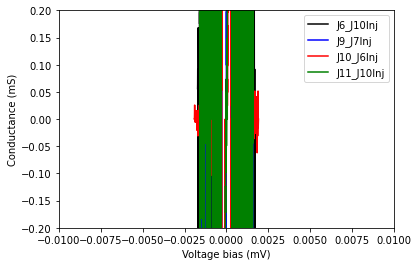

In [554]:
d2IdV2_086 = secdIdV(dIdV_086new, v_086)
d2IdV2_094 = secdIdV(dIdV_094new, v_094)
d2IdV2_083 = secdIdV(dIdV_083new, v_083)
d2IdV2_106 = secdIdV(dIdV_106new, v_106)

plt.plot([x for x in v_086],[y for y in d2IdV2_086], color='black', label='J6_J10Inj')
plt.plot([x for x in v_094],[y for y in d2IdV2_094], color='blue', label='J9_J7Inj')
plt.plot([x for x in v_083],[y for y in d2IdV2_083], color='red', label='J10_J6Inj')
plt.plot([x for x in v_106],[y for y in d2IdV2_106], color='green', label='J11_J10Inj')

plt.xlabel('Voltage bias (mV)')
plt.ylabel('Conductance (mS)')
plt.xlim(-0.01, 0.01)
plt.ylim(-0.2,0.2)
plt.legend()


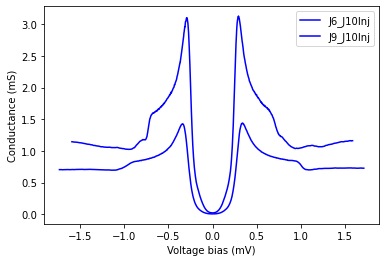

In [533]:
#Comparison of measurement junction (for negative direction of injection)

plt.plot([x*1e3 for x in v_090],[y*1e3 for y in dIdV_090new], color='black', label='J6_J10Inj')
plt.plot([x*1e3 for x in v_112],[y*1e3 for y in dIdV_112new], color='blue', label='J9_J10Inj')
plt.xlabel('Voltage bias (mV)')
plt.ylabel('Conductance (mS)')
#plt.xlim(0.79, 0.80)
#plt.ylim(1.15, 3.2)
plt.legend()

In [ ]:
#Taki

[1606 1974 2029 2083 2448]
{'prominences': array([1.758588e-04, 2.670302e-05, 2.357500e-04, 2.670302e-05,
       1.747150e-04]), 'left_bases': array([ 313, 1960, 1992, 2067, 2067]), 'right_bases': array([2066, 1992, 2066, 2097, 3663])}


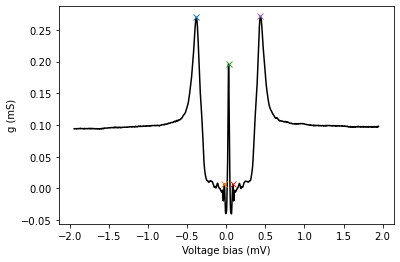

In [524]:
with open(SIN_flist4[0]) as f:
        lines = f.readlines()
        x0 = [float(line.split()[0]) for line in lines]
        x1 = [float(line.split()[1]) for line in lines]
        x2 = [float(line.split()[2]) for line in lines]
        y1 = [float(line.split()[3]) for line in lines]
        
v = [x*dc_fac for x in x0]           #raw data bias
g = [y1/femto/R for y1 in x1]        #raw data conductance (S)
g_oop = [y1/femto/R for y1 in x2]    #raw data out-of-plane conductance (S)
i_raw = [z/femto for z in y1]            #raw data current (A)
    
#Using the scipy.signal.peakfind, we next identify the indices of the peaks (peakind) 
#NormalData
peakind, properties = find_peaks(g,distance=50, prominence=(2e-05, 5.33296e-03))  # when the function does not work, distance may often help
    
#SIN_data_zeroInjection
#peakind, properties = find_peaks(g, prominence=(4.0e-05, 1.0e-03))  # when the function does not work, distance may often help
 
    
#Visualization 1
plt.plot([x*1e3 for x in v],[y*1e3 for y in g], color='black', label='g(v_bias) raw data')
    
for i in range(0,len(peakind)):
    plt.plot(v[peakind[i]]*1e3, g[peakind[i]]*1e3, 'x')
        
plt.xlabel("Voltage bias (mV)")
plt.ylabel("g (mS)")
        
print(peakind)
print(properties)

[ 915 1479]
198
199
200
2198
2199
2200


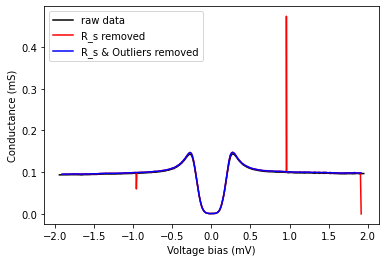

In [436]:
#J6_Measured at O10
v_083, dIdV_083, dIdV_083new,I_083 = remove_Rs(SIN_flist[2], dc_fac,femto,R)

[ 767 1550]
198
199
200
1783
1784
1811
2198
2199
2200


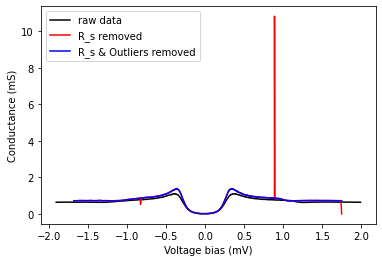

In [438]:
#J9_Measured at O6
v_114, dIdV_114, dIdV_114new,I_114 = remove_Rs(SIN_flist[19], dc_fac,femto,R)

[ 830 1571]
198
199
200
2198
2199
2200
2203
2204
2232
2233
2234
2275
2276


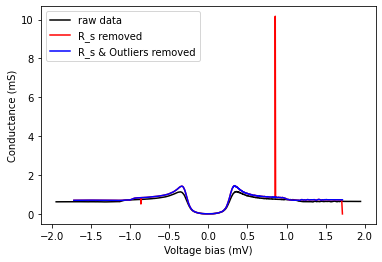

In [439]:
#J10 Measured at O6
v_087, dIdV_087, dIdV_087new,I_087 = remove_Rs(SIN_flist[5], dc_fac,femto,R)

[ 837 1582]
198
199
200
2198
2199
2200
2235
2236


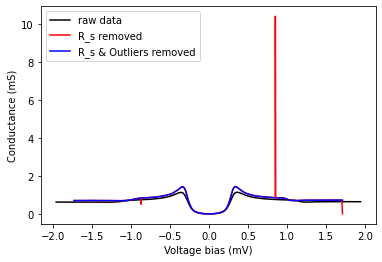

In [442]:
#J10 Measured at O6, negative sweep
v_090, dIdV_090, dIdV_090new,I_090 = remove_Rs(SIN_flist[8], dc_fac,femto,R)

In [443]:
#J10 Measured at O9
v_104, dIdV_104, dIdV_104new,I_104 = remove_Rs(SIN_flist[14], dc_fac,femto,R)

[]
Error: Peakfind properties have to be changed. Copy lines 15 thru 28 on a new cell, and change prominence bound to "(None, 1)". Then open the file with these lines of codes and add print(properties["prominences"], change the prominence bounds inside the function based from these values.


UnboundLocalError: local variable 'v_corr' referenced before assignment

[ 707 1023 1095 1142 1264 1309 1381 1696]
{'prominences': array([0.00151807, 0.00084687, 0.00017014, 0.0003109 , 0.00030422,
       0.00017281, 0.00083409, 0.00150852]), 'left_bases': array([ 140,  957, 1082, 1082, 1232, 1295, 1232, 1232]), 'right_bases': array([1174, 1174, 1110, 1174, 1323, 1323, 1448, 2277])}


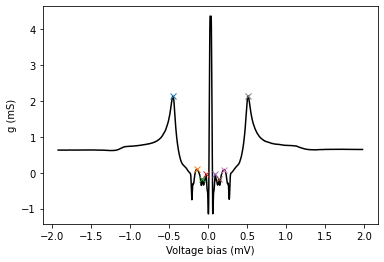

In [498]:
with open(SIN_flist[9]) as f:
        lines = f.readlines()
        x0 = [float(line.split()[0]) for line in lines]
        x1 = [float(line.split()[1]) for line in lines]
        x2 = [float(line.split()[2]) for line in lines]
        y1 = [float(line.split()[3]) for line in lines]
        
v = [x*dc_fac for x in x0]           #raw data bias
g = [y1/femto/R for y1 in x1]        #raw data conductance (S)
g_oop = [y1/femto/R for y1 in x2]    #raw data out-of-plane conductance (S)
i_raw = [z/femto for z in y1]            #raw data current (A)
    
#Using the scipy.signal.peakfind, we next identify the indices of the peaks (peakind) 
#NormalData
peakind, properties = find_peaks(g, prominence=(2e-05, 5.33296e-03))  # when the function does not work, distance may often help
    
#SIN_data_zeroInjection
#peakind, properties = find_peaks(g, prominence=(4.0e-05, 1.0e-03))  # when the function does not work, distance may often help
 
    
#Visualization 1
plt.plot([x*1e3 for x in v],[y*1e3 for y in g], color='black', label='g(v_bias) raw data')
    
for i in range(0,len(peakind)):
    plt.plot(v[peakind[i]]*1e3, g[peakind[i]]*1e3, 'x')
        
plt.xlabel("Voltage bias (mV)")
plt.ylabel("g (mS)")
        
print(peakind)
print(properties)
    

[ 830 1571]
198
199
200
2198
2199
2200


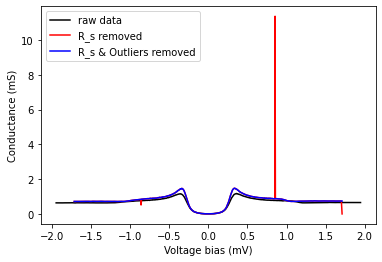

In [440]:
#J11 Measured at O6
v_105, dIdV_105, dIdV_105new,I_105 = remove_Rs(SIN_flist[15], dc_fac,femto,R)

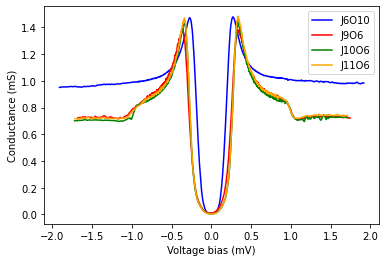

In [450]:
plt.plot([x*1e3 for x in v_083],[y*1e3*10 for y in dIdV_083new], color='blue', label='J6O10')
plt.plot([x*1e3 for x in v_114],[y*1e3 for y in dIdV_114new], color='red', label='J9O6')
#plt.plot([x*1e3 for x in v_112],[y*1e3 for y in dIdV_112new], color='green', label='J10')
plt.plot([x*1e3 for x in v_087],[y*1e3 for y in dIdV_087new], color='green', label='J10O6')
plt.plot([x*1e3 for x in v_105],[y*1e3 for y in dIdV_105new], color='orange',label='J11O6')

plt.xlabel('Voltage bias (mV)')
plt.ylabel('Conductance (mS)')
#plt.xlim(0.79, 0.80)
#plt.ylim(1.15, 3.2)
plt.legend()

In [283]:
#Just like remove_Rs but here, we removed the distance to be in peakfind

#Input arguments:
#path: define the file location and the file in the form: "\filelocation\filename"
#dc_fac: DC factor can be found in the lab notebook
#femto: gain setting (V/A)
#R: resistor in the lock-in (Ohms)

#returns:
#v_corr: corrected voltage bias. Offset and line voltage drop removed
#dI_dV: corrected conductance spectrum. differentiated g_int wrt v_corr
#g_oop: untreated out-of-plane conductance
#g_int: integral of g. representative of the 

def SIN_remove_Rs(path, dc_fac, femto, R):
    
    with open(path) as f:
        lines = f.readlines()
        x0 = [float(line.split()[0]) for line in lines]
        x1 = [float(line.split()[1]) for line in lines]
        x2 = [float(line.split()[2]) for line in lines]
        y1 = [float(line.split()[3]) for line in lines]
        
    v = [x*dc_fac for x in x0]           #raw data bias
    g = [y1/femto/R for y1 in x1]        #raw data conductance (S)
    g_oop = [y1/femto/R for y1 in x2]    #raw data out-of-plane conductance (S)
    i_raw = [z/femto for z in y1]            #raw data current (A)
    
    #Using the scipy.signal.peakfind, we next identify the indices of the peaks (peakind) 
    peakind, properties = find_peaks(g, prominence=(4.0e-05, 1.0e-03))  # when the function does not work, distance may often help
        
    #Visualization 1
    #plt.plot([x*1e3 for x in v],[y*1e3 for y in g], color='black', label='g(v_bias) raw data')
    
    #for i in range(0,len(peakind)):
    #    plt.plot(v[peakind[i]]*1e3, g[peakind[i]]*1e3, 'x')
        
    #plt.xlabel("Voltage bias (mV)")
    #plt.ylabel("g (mS)")
        
    print(peakind)
    print(properties)
    
    if len(peakind) == 2:
                
        #The center of the peaks corresponds to the bias offset
        v_offset = (v[peakind[1]]+v[peakind[0]])*0.5
        #print (v_offset)
    
        #Removing the offset from the data
        v_bare = [x-v_offset for x in v]
        
        #Visualization 2
        #plt.plot([x*1e3 for x in v],[y*1e3 for y in g], color='black', label='raw data')
        #plt.plot([x*1e3 for x in v_bare],[y*1e3 for y in g], color='red', label='bias offset removed')
        #plt.legend()
        #plt.xlim(0.30,0.6)
        #plt.ylim(1.2,1.5)
        #plt.xlabel("Voltage bias (mV)")
        #plt.ylabel("g (mS)")
        
        #Next, remove the current offset using the IV curve. To this, we first use the v_bare to be
        #the x-axis of the IV curve, and from there, we identify the  value of I(0) and force it to be 0.
        
        z=min(np.absolute(v_bare))       #take the absolute value of the a_new and find the minimum, which corresponds to the number closest to zero if it is not zero. 
        
        p = z in v_bare
        
        if p==True:                          #use an if-statement to find the index of that minimum element of v_bare as we took its absolute value to identify the minimum but it can be positive or negative. 
            v_bare_min= v_bare.index(z)      
        else: 
            v_bare_min= v_bare.index(-z)
            
        I_offset= i_raw[v_bare_min]          # I-offset is defined by the current value at the zero bias.
        i_bare = [x-I_offset for x in i_raw]  # d_new is the checked current
        
        #Visualization 3
        #print(z)
        #print(v_bare)
        #print(v_bare_min)
        #print(I_offset)
        #plt.plot([x*1e3 for x in v], [y*1e6 for y in i], color='black')
        #plt.plot([x*1e3 for x in v_bare], [y*1e6 for y in i_bare], color='red')
        #plt.plot([x*1e3 for x in v_bare], [y*1e6 for y in i_bare], color='blue')
        #plt.xlim(-0.1,0.1)
        #plt.ylim(-0.005,0.005)
        #plt.xlabel("Voltage bias (mV)")
        #plt.ylabel("I (uA)")
        
        #For sanity check, we want to integrate g wrt v_bare, and compare it with the (v_bare, i_bare) plot.
        #Ideally, they should be the same but since g is measured with the lock-in, it turns out to be smoother
        #than I, so we must use the integral of g instead of i in succeeding calculation.
        
        g_integration = integrate.cumtrapz(g,v_bare)
        g_integ=np.append(g_integration, g_integration[-1])
        I_offset2 = g_integ[v_bare_min]
        g_int = [x-I_offset2 for x in g_integ]
        
        #visualization4
        #plt.plot([x*1e3 for x in v_bare], [y*1e6 for y in i_bare], color='black', label='current, I')
        #plt.plot([x*1e3 for x in v_bare], [y*1e6 for y in g_int], color='red', label='integrated conductance, g_int')
        #plt.xlabel("Voltage bias (mV)")
        #plt.ylabel("I (uA)")
        #plt.legend()
        
        #Now, we want to remove the voltage drop contribution from the femto and the lines using Kirchoff's rule,
        #and knowing that the femto input impedance is 120 Ohms for 10^6 gain and another 120 Ohms from measuring
        #the lines, which gives a total of 240 Ohms for unwanted voltage drop.
        
        if femto == 1e6:
            R_femto=60
        else :
            R_femto=150
        
        
        R_lines=120
        R_ser= R_femto + R_lines

        v_corr= [y - x*R_ser for y, x in zip(v_bare, g_int)]

        #print(len(g_int))
        #print(len(v_corr))

        #next, we take the derivative of g_int wrt the v_corr

        dI_dV = np.gradient(g_int, v_corr)

        plt.plot([x*1e3 for x in v_bare], [y*1e3 for y in g], color='black', label='raw data')
        plt.plot([x*1e3 for x in v_corr], [y*1e3 for y in dI_dV], color='red', label='R_s removed')
        plt.xlabel('Voltage bias (mV)')
        plt.ylabel('Conductance (mS)')
        #plt.xlim(0.79, 0.80)
        #plt.ylim(1.15, 3.2)
        plt.legend()
        
        
    else:
                
        print('Error: Peakfind properties have to be changed. Copy lines 15 thru 28 on a new cell, and change prominence bound to "(None, 1)". Then open the file with these lines of codes and add print(properties["prominences"], change the prominence bounds inside the function based from these values.')
       
    return v_corr, dI_dV, g_oop, g_int

In [290]:
#Some of the derivatives of g_int wrt v_corr have divergence at specific points.
#The origin is not understood but certainly not from the raw data. So it could be
#due to the built-in function itself. To remove them, we identify the points and replace 
#with the average of the neighbors.

def SIN_remove_DiracOutliers(dIdV):
    dIdV_new=dIdV
    #Positive peaks
    peakindp, propertiesp = find_peaks(dIdV_new, prominence=(4e-4, 40e-3))
    print('peakindp=', peakindp)
    print('propertiesp=', propertiesp)
    for i in range(len(peakindp)):
        #plt.plot(v_083[peakindp[i]]*1e3, dIdV_new[peakindp[i]]*1e3, 'x')
        dIdV_new[peakindp[i]] = (dIdV_new[peakindp[i]-3]+ dIdV_new[peakindp[i]+ 3])/2
        dIdV_new[peakindp[i]+1] = (dIdV_new[peakindp[i]]+dIdV_new[peakindp[i]+3])/2
        dIdV_new[peakindp[i]-1] = (dIdV_new[peakindp[i]]+dIdV_new[peakindp[i]-3])/2
            
    #Negative peaks
    peakindn, propertiesn = find_peaks(-dIdV_new,  prominence=(3.5e-5, 5e-4))
    print('peakindn=',peakindn)
    print('propertiesn=', propertiesn)
    for i in range(len(peakindn)):
        plt.plot(v_083[peakindn[i]]*1e3, dIdV_new[peakindn[i]]*1e3, 'x')
        dIdV_new[peakindn[i]] = (dIdV_new[peakindn[i]-3]+ dIdV_new[peakindn[i]+ 3])/2
        dIdV_new[peakindn[i]+1] = (dIdV_new[peakindn[i]]+dIdV_new[peakindn[i]+3])/2
        dIdV_new[peakindn[i]-1] = (dIdV_new[peakindn[i]]+dIdV_new[peakindn[i]-3])/2
    
    #Divergence at the end of the data
    for i in range(-3,0):
        dIdV_new[i] = dIdV_new[-3]
    
    return dIdV_new
#    return(dIdV_new,peakindp, propertiesp, peakindn,propertiesn)

[ 915 1479]
{'prominences': array([4.99730e-05, 4.80656e-05]), 'left_bases': array([  58, 1226]), 'right_bases': array([1167, 2339])}


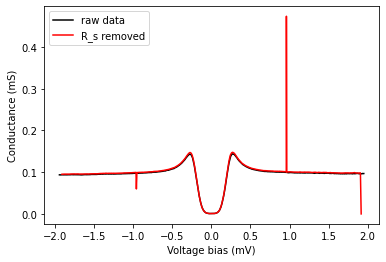

In [285]:
dc_fac =9.739E-3
femto = 1e6
R = 5e-6

v_083, dIdV_083, g_oop_083,I_083 = SIN_remove_Rs(flist1[15], dc_fac,femto,R)

peakindp= [2200]
propertiesp= {'prominences': array([0.00047283]), 'left_bases': array([1220]), 'right_bases': array([2400])}
peakindn= [ 199 1219]
propertiesn= {'prominences': array([3.95682662e-05, 1.46471657e-04]), 'left_bases': array([198, 914]), 'right_bases': array([ 914, 1478])}


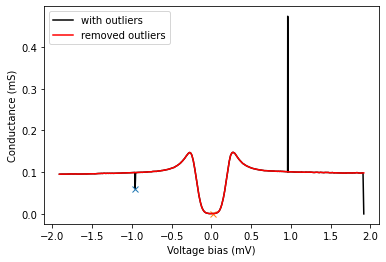

In [286]:
plt.plot([x*1e3 for x in v_083],[y*1e3 for y in dIdV_083], color='black', label='with outliers')
dIdV_083new=SIN_remove_DiracOutliers(dIdV_083)
plt.plot([x*1e3 for x in v_083],[y*1e3 for y in dIdV_083new], color='red', label='removed outliers')
plt.xlabel('Voltage bias (mV)')
plt.ylabel('Conductance (mS)')
#plt.xlim(0.79, 0.80)
#plt.ylim(1.15, 3.2)
plt.legend()

[ 767 1550]
{'prominences': array([0.00047875, 0.00048065]), 'left_bases': array([ 121, 1163]), 'right_bases': array([1131, 2249])}


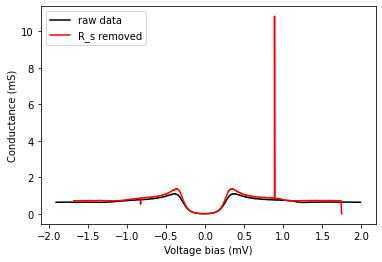

In [287]:
dc_fac =9.739E-3
femto = 1e6
R = 5e-6

v_090, dIdV_090, g_oop_090,I_090 = SIN_remove_Rs(flist1[13], dc_fac,femto,R)

peakindp= [ 766 1549 2200]
propertiesp= {'prominences': array([0.0008613 , 0.00052174, 0.01081623]), 'left_bases': array([ 199, 1159, 1159]), 'right_bases': array([1158, 2188, 2400])}
peakindn= [199]
propertiesn= {'prominences': array([0.0003341]), 'left_bases': array([198]), 'right_bases': array([755])}


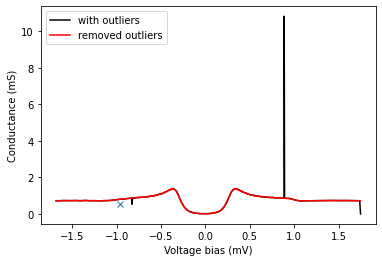

In [288]:
plt.plot([x*1e3 for x in v_090],[y*1e3 for y in dIdV_090], color='black', label='with outliers')
dIdV_090new=SIN_remove_DiracOutliers(dIdV_090)
plt.plot([x*1e3 for x in v_090],[y*1e3 for y in dIdV_090new], color='red', label='removed outliers')
plt.xlabel('Voltage bias (mV)')
plt.ylabel('Conductance (mS)')
#plt.xlim(0.79, 0.80)
#plt.ylim(1.15, 3.2)
plt.legend()

In [444]:
dc_fac =9.739E-3
femto = 1e6
R = 5e-6

v_112, dIdV_112, g_oop_112,I_112 = SIN_remove_Rs(flist1[7], dc_fac,femto,R)
plt.xlim(-1.25,1.15)
plt.xlim(0,5)

[ 620  923 1085 1236 1537]
{'prominences': array([2.313628e-04, 4.763640e-05, 6.386320e-04, 4.782720e-05,
       2.313624e-04]), 'left_bases': array([ 129,  850, 1014, 1148, 1148]), 'right_bases': array([1014, 1014, 1148, 1307, 2219])}
Error: Peakfind properties have to be changed. Copy lines 15 thru 28 on a new cell, and change prominence bound to "(None, 1)". Then open the file with these lines of codes and add print(properties["prominences"], change the prominence bounds inside the function based from these values.


UnboundLocalError: local variable 'v_corr' referenced before assignment

peakindp= [ 757 1537 2200]
propertiesp= {'prominences': array([0.00174083, 0.00130569, 0.03710807]), 'left_bases': array([ 199, 1151, 1151]), 'right_bases': array([1151, 2198, 2400])}
peakindn= [ 153  199 2239]
propertiesn= {'prominences': array([1.11964389e-04, 4.51182847e-04, 7.29794451e-05]), 'left_bases': array([   8,  198, 1518]), 'right_bases': array([ 198,  755, 2390])}


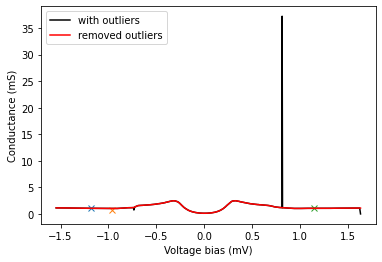

In [291]:
plt.plot([x*1e3 for x in v_112],[y*1e3 for y in dIdV_112], color='black', label='with outliers')
dIdV_112new=SIN_remove_DiracOutliers(dIdV_112)
plt.plot([x*1e3 for x in v_112],[y*1e3 for y in dIdV_112new], color='red', label='removed outliers')
plt.xlabel('Voltage bias (mV)')
plt.ylabel('Conductance (mS)')
#plt.xlim(0.79, 0.80)
#plt.ylim(1.15, 3.2)
plt.legend()

[ 830 1571]
{'prominences': array([0.00053311, 0.0005352 ]), 'left_bases': array([ 128, 1207]), 'right_bases': array([1189, 2249])}


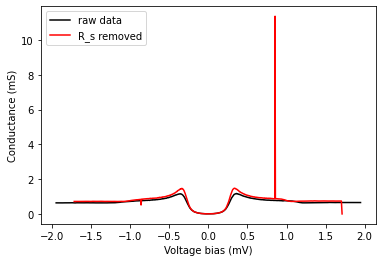

In [295]:
dc_fac =9.739E-3
femto = 1e6
R = 5e-6

v_105, dIdV_105, g_oop_105,I_105 = SIN_remove_Rs(flist1[14], dc_fac,femto,R)

peakindp= [ 829 1570 2200]
propertiesp= {'prominences': array([0.00095708, 0.00062117, 0.01136724]), 'left_bases': array([ 199, 1194, 1194]), 'right_bases': array([1191, 2180, 2400])}
peakindn= [199]
propertiesn= {'prominences': array([0.00032305]), 'left_bases': array([198]), 'right_bases': array([831])}


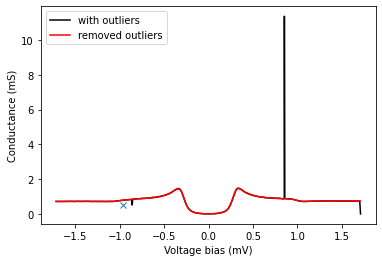

In [296]:
plt.plot([x*1e3 for x in v_105],[y*1e3 for y in dIdV_105], color='black', label='with outliers')
dIdV_105new=SIN_remove_DiracOutliers(dIdV_105)
plt.plot([x*1e3 for x in v_105],[y*1e3 for y in dIdV_105new], color='red', label='removed outliers')
plt.xlabel('Voltage bias (mV)')
plt.ylabel('Conductance (mS)')
#plt.xlim(0.79, 0.80)
#plt.ylim(1.15, 3.2)
plt.legend()

[ 767 1550]
{'prominences': array([0.00047875, 0.00048065]), 'left_bases': array([ 121, 1163]), 'right_bases': array([1131, 2249])}


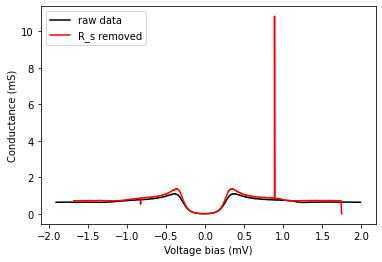

In [349]:
dc_fac =9.739E-3
femto = 1e6
R = 5e-6

v_114, dIdV_114, g_oop_114,I_114 = SIN_remove_Rs(flist1[13], dc_fac,femto,R)

diffn= 6.367052194783396e-07
diffn= 5.10009350612739e-07
diffn= -0.0003340963585547127
diffn= 0.00022972711259185846
diffn= 0.00010793623512250772
diffp= 1.931883842301585e-06
diffp= 1.1895938026168507e-06
diffp= -1.9312211450572825e-06
diffp= -6.531288398309298e-06
diffp= -9.185881737663881e-06
diffp= -9.458738065529215e-06
diffp= -7.2277869831022246e-06
diffp= -4.12205730768167e-06
diffp= -1.3237400841581426e-06
diffp= 2.06074507487497e-06
diffp= 2.795711093558917e-06
diffp= 1.7667573958546345e-06
diffp= 1.620768479565493e-06
peakindp= [ 766 1549 2200]
propertiesp= {'prominences': array([0.0008613 , 0.00052174, 0.01081623]), 'left_bases': array([ 199, 1159, 1159]), 'right_bases': array([1158, 2188, 2400])}
peakindn= [199]
propertiesn= {'prominences': array([0.0003341]), 'left_bases': array([198]), 'right_bases': array([755])}
diffn_post= 6.367052194783396e-07
diffn_post= 4.780783848835901e-07
diffn_post= 1.1147836043619297e-06
diffn_post= 1.1147836043619297e-06
diffn_post= 1.36935291

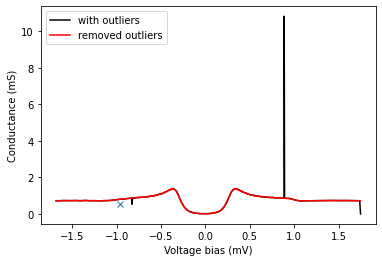

In [350]:
plt.plot([x*1e3 for x in v_114],[y*1e3 for y in dIdV_114], color='black', label='with outliers')

for i in range(196,201):
    diffn = dIdV_114[i+1]-dIdV_114[i]
    print('diffn=', diffn) 
    
for i in range(1547,1560):
    diffp = dIdV_114[i+1]-dIdV_114[i]
    print('diffp=', diffp) 
    
dIdV_114new=SIN_remove_DiracOutliers(dIdV_114)

for i in range(196,201):
    diffn_post = dIdV_114new[i+1]-dIdV_114new[i]
    print('diffn_post=', diffn_post) 
    
for i in range(1530,1560):
    diffp_post = dIdV_114new[i+1]-dIdV_114new[i]
    print('diffp_post=', diffp_post) 

    
plt.plot([x*1e3 for x in v_114],[y*1e3 for y in dIdV_114new], color='red', label='removed outliers')
plt.xlabel('Voltage bias (mV)')
plt.ylabel('Conductance (mS)')
#plt.xlim(0.79, 0.80)
#plt.ylim(1.15, 3.2)
plt.legend()

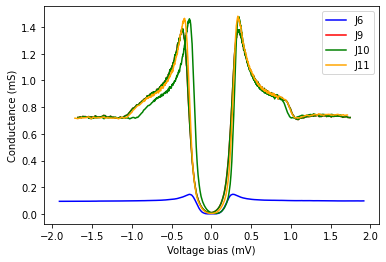

In [301]:
plt.plot([x*1e3 for x in v_083],[y*1e3 for y in dIdV_083new], color='blue', label='J6')
plt.plot([x*1e3 for x in v_114],[y*1e3 for y in dIdV_114new], color='red', label='J9')
plt.plot([x*1e3 for x in v_112],[y*1e3 for y in dIdV_112new], color='green', label='J10')
plt.plot([x*1e3 for x in v_090],[y*1e3 for y in dIdV_090new], color='green')
plt.plot([x*1e3 for x in v_105],[y*1e3 for y in dIdV_105new], color='orange',label='J11')

plt.xlabel('Voltage bias (mV)')
plt.ylabel('Conductance (mS)')
#plt.xlim(0.79, 0.80)
#plt.ylim(1.15, 3.2)
plt.legend()

In [394]:

left_range=range(-1,2)
right_range=range(4,10)

for i in itertools.chain(left_range,right_range):
    print(i)
    
a=itertools.chain(left_range,right_range)
print(a(-2))

-1
0
1
4
5
6
7
8
9


TypeError: 'itertools.chain' object is not callable

In [380]:
print(range(0,10))

range(0, 10)
